In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [6]:
qb = 0 # qubit to operate on

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 0 has a 
  - T1 time of 83.61435016268965 microseconds
  - T2 time of 88.37645041224076 microseconds
  - U2 gate error of 0.00021586213630685392
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.664862530659801 GHz


In [7]:
shots = 1024 # determines clarity of results

period = 100 # Rabi oscillation period
cycles = [5,20,40,80,160] # number of rabi cycles to perform for each oscillation
datapoints_per_period = 50 # density of datapoints in a cycle capture
cycles_to_plot = 4 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const = 54.07447683508908
predict_power =  -0.9924372112785861

sig_predict_const = 11.48089749887833 
sig_predict_power = -0.9672752940591574

In [8]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)
s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = int(s(drive_amp))
print(drive_amp)
print(drive_sigma)

for cycle in cycles:
    drive_duration = period*cycle    
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = 6
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        16)
    
    times = []
    for i in range(len(drive_times)):    
        
        rabi_pulse = pulse_lib.GaussianSquare(duration=drive_times[i], 
                                        amp=drive_amp, 
                                        sigma=drive_sigma,
                                        width=drive_times[i]-(2*drive_sigma),
                                        name=f"Rabi duration = {i}")
        
        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        this_schedule += Play(rabi_pulse, drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

0.5382172534307658
20


In [9]:
su = 0
for d in data_times:
    su += sum(d)
print(su)

730944


In [81]:
# split up the cycles into batches and run as multiple jobs
batched_experiments = []
samples = 0
batch = []

for i in range(len(data_times)):
    times = data_times[i]
    for j in range(len(times)):
        if (samples + times[j] < 230000):
            batch.append(experiments[(i * len(times) + j)])
            samples += times[j]
        else:
            schedule = pulse.Schedule(name='|0> state')
            schedule += measure << schedule.duration
            batch.append(schedule) # add zero state to experiments

            batched_experiments.append(batch)
            samples = 0
            batch = []
            batch.append(experiments[(i * len(times) + j)])
            
batched_experiments.append(batch)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
batched_experiments[-1].append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
batched_experiments[-1].append(schedule) # add 1 state to experiments

print(f'Split into {len(batched_experiments)} jobs')

Split into 4 jobs


In [11]:
benewop_jobs = []
num_shots_per_point = 1024

for i in range(len(batched_experiments)):
    program = assemble(batched_experiments[i],
                       backend=backend,
                       meas_level=1,
                       meas_return='avg',
                       shots=num_shots_per_point)
    job = backend.run(program)
    benewop_jobs.append(job.job_id())

In [12]:
benewop_jobs

['5ef4b98f5faf0900143b1aba',
 '5ef4b99884b1b70012374abb',
 '5ef4b9a25faf0900143b1abf',
 '5ef4b9acddb6500012078672']

In [68]:
def normalize_results(baseline, values):
    #  accounts for the differences in IQ angle between jobs and makes all of the jobs align to one job
    new_values = [x + (baseline - values[-1]) for x in values]
    new_values.pop()
    return new_values
    
all_results = []
baseline = 0
for i in range(len(benewop_jobs))[::-1]:
    job = backend.retrieve_job(benewop_jobs[i])
    results = job.result(timeout=120)
    
    one_res = []
    for j in range(len(batched_experiments[i])):
        one_res.append(results.get_memory(j)[qb] * scale_factor)
    one_res = np.angle(one_res, deg=True)
    
    if  (i == len(benewop_jobs) - 1):
        baseline = np.angle(results.get_memory(len(batched_experiments[i])-2)[qb] * scale_factor, deg=True)
    else:
        one_res = normalize_results(baseline, one_res)
    all_results[0:0] = one_res

-77.01837598614094


In [69]:
qb_rabi_data = []
all_params = []
all_fits = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 0])
    all_params.append(p)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    all_fits.append(y_fit)

Period: 106.75840036348858 dt


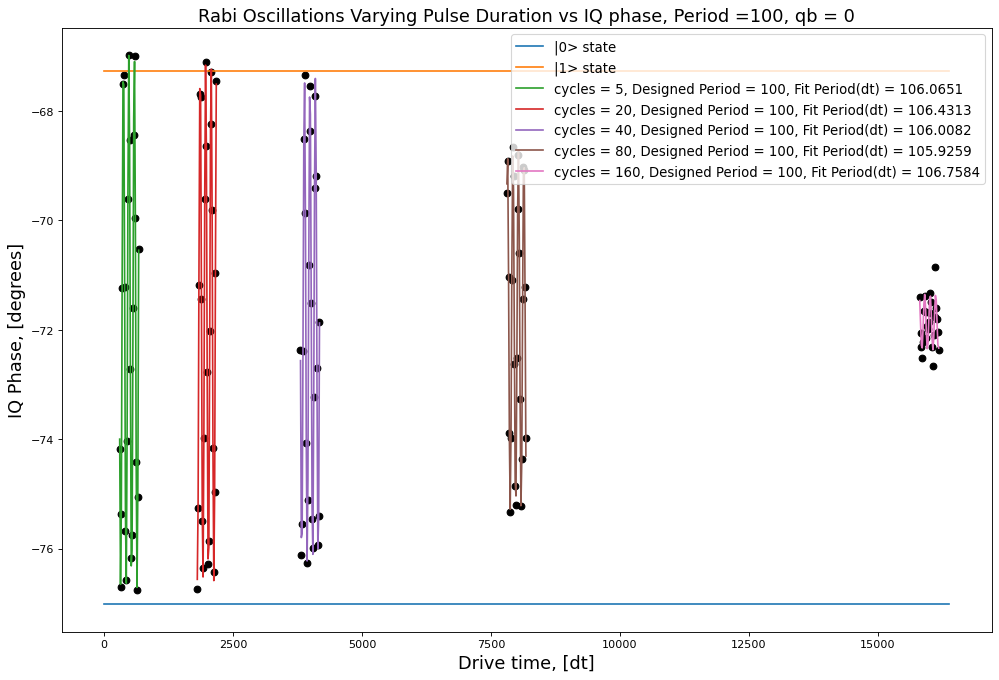

In [80]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

end_plot_time = (period*cycles[-1])+(len(data_times[-1])*16)
plt.plot([0, end_plot_time],2*[state0],label="|0> state")
plt.plot([0, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
print(f'Period: {p[2]} dt')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [71]:
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')

9.769644678747156
9.635958188099963
8.927072215468513
6.668345907051631
1.8200008774139889


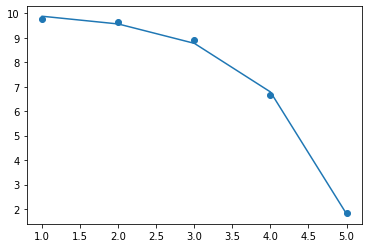

In [90]:
amps = [np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i]) for i in range(len(cycles))]

fit = lambda x, a, b, c: a * np.exp(-b * x) + c
p = fit_function([1,2,3,4,5], amps, fit, [3, -1, -1])
y_fit = [fit(x, p[0], p[1], p[2]) for x in [1,2,3,4,5]]

plt.scatter([1,2,3,4,5], amps)
plt.plot([1,2,3,4,5], y_fit)
